Solving for theorteical flux values given the parameters. Compare this model with the actual kepler data from t=261 to t=262. The kepler data has been normalzied using a standard deviation and a mean that has been calculated using a 2 sigma clipping algorithmn.

Flux vs time collected fromt he Kepler Satellite, from the lightcurve data from host star of Kepler 7b.

In [ ]:
import numpy as np
import lightkurve as lk
import matplotlib.pyplot as plt
import math

#this is for the incomplete gamma function used in find the P-value of our Chi-Sqaure value
from scipy.special import gammaincc

# for graph sizes
plt.rcParams['figure.figsize'] = [18, 11]

In [ ]:
def get_curve(name):
    lcs = lk.search_lightcurve(name, mission="Kepler", cadence="short").download_all()
    time = lcs[0].time.value # get the time of each observation
    flux = np.array(lcs[0].flux.value.data) # get the flux
    flux_err = np.array(lcs[0].flux_err.value.data) # get the error in the flux
    return (time, flux, flux_err)

(time, flux, flux_err) = get_curve("Kepler-7b")

Extact data in time range 261<t<262

In [ ]:
start_time = 261
end_time = 262

# Create a mask to extract data within the specified time range
mask = np.logical_and(time >= start_time, time <= end_time)

# Extract data within the specified time range using the mask
time = time[mask]
flux = flux[mask]
flux_err = flux_err[mask]

#print(flux)
#print(time)
#print(flux_err)

Normalize the extracted data by refining the mean and standard deviation.

In [ ]:
def normalize(flux, flux_error):
    num_iterations = 5

    #mean & stand deviation
    mean_flux = np.mean(flux)
    std_flux = np.std(flux)
    # make a copy of flux
    excluding_flux = []
    excluding_flux = flux

    # Two-sigma clipping algorithm
    for _ in range(num_iterations):
        # Exclude points more than 2 sigma away from the mean
        mask = np.abs(excluding_flux - mean_flux) / std_flux <= 2
        excluding_flux = excluding_flux[mask]

        # Update mean &std
        mean_flux = np.mean(excluding_flux)
        std_flux = np.std(excluding_flux)

    # Normalize flux values and uncertainty
    normalized_flux = flux / mean_flux
    normalized_flux_error = flux_error / mean_flux

    #make sure the arrays ore of the same size.
    print(len(normalized_flux))
    print(len(time))

    return (normalized_flux, normalized_flux_error)

flux = np.array(flux)
flux_err=np.array(flux_err)
(normalized_flux, normalized_flux_error) = normalize(flux,flux_err)

print(normalized_flux)
print(normalized_flux_error)

1456
1456
[0.9996699 1.0003825 1.0001546 ... 1.001422  0.9993011 0.9994306]
[0.00048732 0.00048759 0.00048806 ... 0.00048934 0.00048816 0.00048823]


Use simpson's rule for integration to write functions that calcuate theoretical flux values, (from PS2), using an updated Limb Darkening function

In [ ]:
def f(p,z,r, flag):   #defintion for the functions in the integrands
  if(flag):  #if flag is true, use the function from integrand in numerator
    deltas= delta(p,z,r)
    return (limbdarkening(r)*(1-deltas)*2*r)
  else:  #else use the function in the integrand of the denominator
    return (limbdarkening(r)*2*r)

def simprule(n,x1,x2,p,z,flag):
  sum =0 #curent intergal approximation
  r=x1 # starting point for integration
  h = (x2-x1)/(n) #(Upperbound-lowerbound)/n will give us width
  #print(h)  #checking for error of bounds and width

  for i in range (0,(n+1)):
      if(i==0 or i==(n)):
        sum += f(p,z,r,flag)
      else:
        if( i%2 ==0):
          sum += 2*f(p,z,r,flag)
        else:
          sum += 4*f(p,z,r,flag)
    #print("x = " + str(x)) # testing iteration
      r= r+h
      i=i+1

  sum = sum*(h/3)  # finally multiply by the width/3
  #print("Integral (Simpsons Rule) for %6d iterations = %12.11f" % (n,sum))
  return sum


def delta(p,z,r):
    if (r>= (z+p) or r<=(z-p)):
        return 0
    if((r+z) <= p):
      return 1
    else:
      val = (np.arccos(((z**2)-(p**2)+(r**2))/(2*z*r)))/math.pi
    return val

#our new limbdarkening function, where r is a distance
def limbdarkening(r):
  u = (1-r**2)**(1/2)
  return u **(1/2)

def integral(n,p,z,flag):
  x1=0 #lowerbound
  x2=1 #upperbound
  sum = simprule(n,x1,x2,p,z,flag)
  return sum

def flux(p,z):
  z = math.fabs(z)
  n=10000
  numerator = integral(n,p,z, True)
  denominator = integral(n,p,z, False)
  fluxVal = (numerator/denominator)
  #print("n= %6d z= %4.2f, flux = %12.11f" %(n,z,fluxVal))
  return fluxVal

compare our array of our extracted kepler data and our newly made array of theoretical flux values

In [ ]:
flux_vals= []
chi_square = 0

p = 0
t0 = 0

def main(time, normalized_flux, normalized_flux_error):
    global p
    global t0
    p = 0.0775
    t0 = 261.3  # time of max eclipse
    tau = 0.1  # estimated time of eclipse
    global chi_square  #use the global value and modify it

    #create an array of the modeled flux values, based on the times in the kepler data
    for times in time:
        z = ((times-t0)/tau)
        flux_value = flux(p, z)
        flux_vals.append(flux_value)
    #print(len(flux_vals))

    for i in range(len(time)):
        #z = (time[i] - t0) / tau
        calculated_flux = flux_vals
        # Make sure the error is not zero to avoid division by zero
        if normalized_flux_error[i] != 0:
            chi_square += ((normalized_flux[i] - calculated_flux[i]) / normalized_flux_error[i]) ** 2
        else:
            print(f"Warning: Eror at index {i} is zero; this point was skipped in calculations.")

    print("Chi-square value:", chi_square)

# Call the main function with parameters
main(time, normalized_flux, normalized_flux_error)

Chi-square value: 1461.9717094914117


Now we have chi-square, we can visualize the the data against the model and then find the P-value of this Chi-squared.

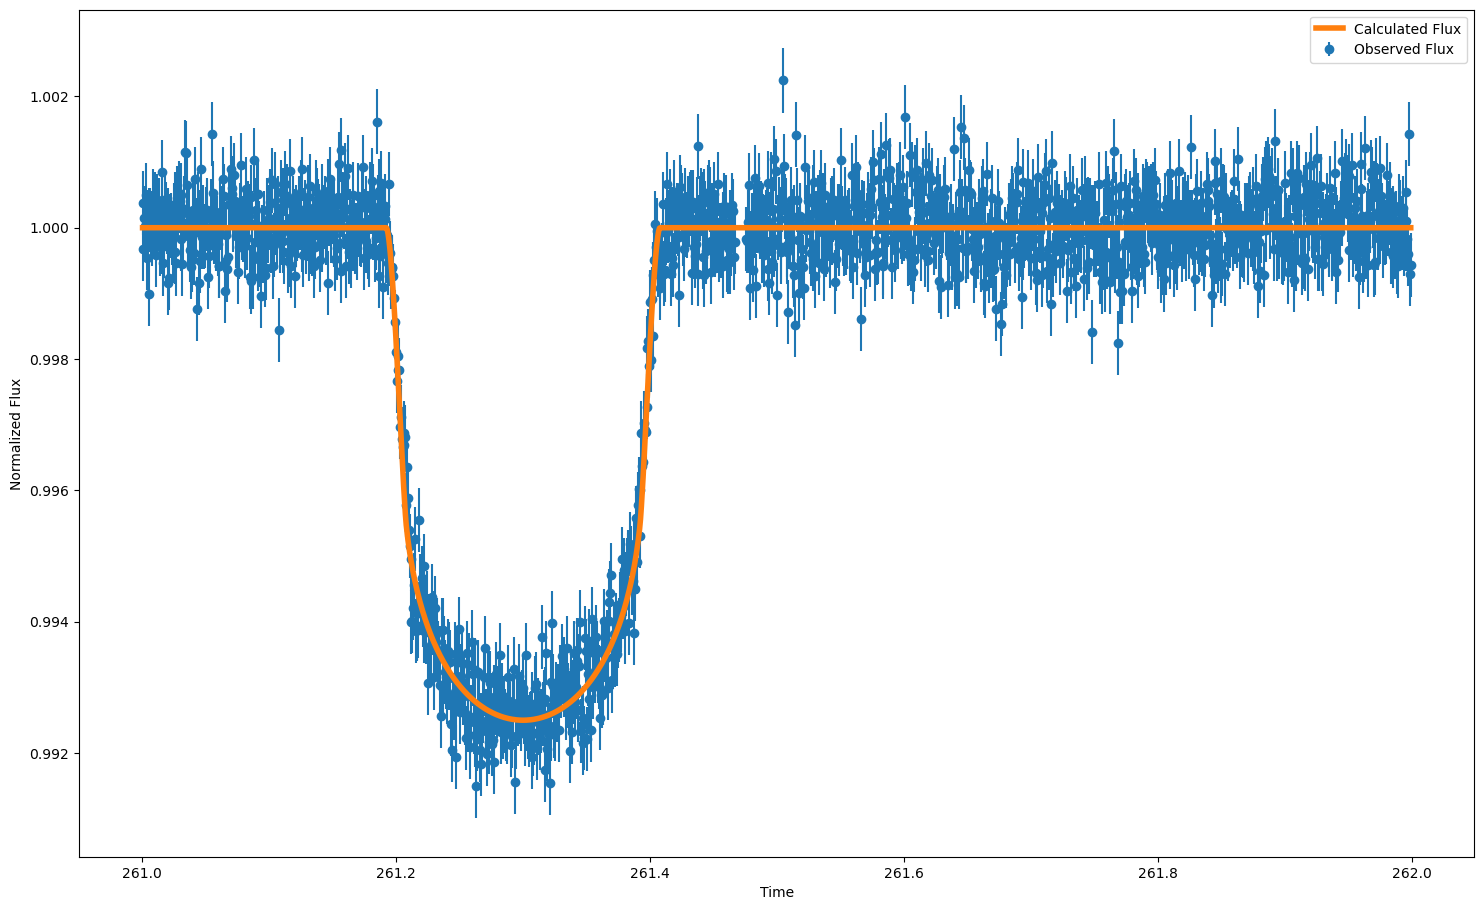

In [ ]:
# Plot the observed data from Kepler Light curve
plt.errorbar(time, normalized_flux, yerr=normalized_flux_error, fmt='o', label='Observed Flux')

# model predictions
model_predictions = flux_vals

# Plot the model
plt.plot(time, model_predictions, label='Calculated Flux', linewidth=4, zorder=10)

# Label the plot
plt.xlabel('Time')
plt.ylabel('Normalized Flux')
plt.legend()

# Display the plot
plt.show()

The model visually fits the Kepler data point well and is a good fit, and we could expect a Chi-square around our degrees of freedom.

In [ ]:
#from scipy.special import gammaincc
#print(chi_square)

N = 1460  # numbr of data points from light curve for 261 to 262
M = 3  # num parameters

# Degrees of freedom
dof = N - M

# Calculate the p-value using the incomplete gamma function (gammaincc)
p_value = gammaincc(dof / 2.0, chi_square / 2.0)

print('Chi_sqaure: '+str(chi_square)+'   P_value:'+str(p_value))

Chi_sqaure: 1461.9717094914117   P_value:0.4584487561702253


This chi-square is close to our degrees of freedom, which should be 1460-3 = 1457, but our P-value is fairly high, above 0.05, where it would have been statistically significant, had it been below that level. But because our P_value is far above 0.05, it not statisitcally significant we can say that the the difference between the theoretical flux values and the actual observed flux value have a high probablity of being due to chance, rather than actual errors in the model.

Vary the transit width τ between 0.08 and 0.13, while keeping the other parameters (p and
t0) constant. Using loop and arays of the resulting Chi-sqaure-values to approximate which Chi-sqaure value is the best

In [ ]:
#create variables to contain the best tau
best_tau = None
min_chi_square = float('inf')
chi_square_vals = []

#create the an array of tau values from 0.08 to 0.13 using 0.005 increments
tau_values = np.arange(0.08, 0.13 + 0.001, 0.005)

# Iterate over tau in increment values of 0.005
for tau in tau_values:
    current_chi_square = 0
    #iterate over the time array from the observered values
    for i in range(len(time)):
        calculated_flux = flux(p, (time[i] - t0) / tau)
        if normalized_flux_error[i] != 0:
            current_chi_square += ((normalized_flux[i] - calculated_flux) / normalized_flux_error[i]) ** 2

    # add Chi-squared values to array
    chi_square_vals.append(current_chi_square)

    # if the current Chi-squared is lower, it becmes the new minimum
    if current_chi_square < min_chi_square:
        min_chi_square = current_chi_square
        best_tau = tau



plot the result and determine the corresponding p-value for the min Chi-square

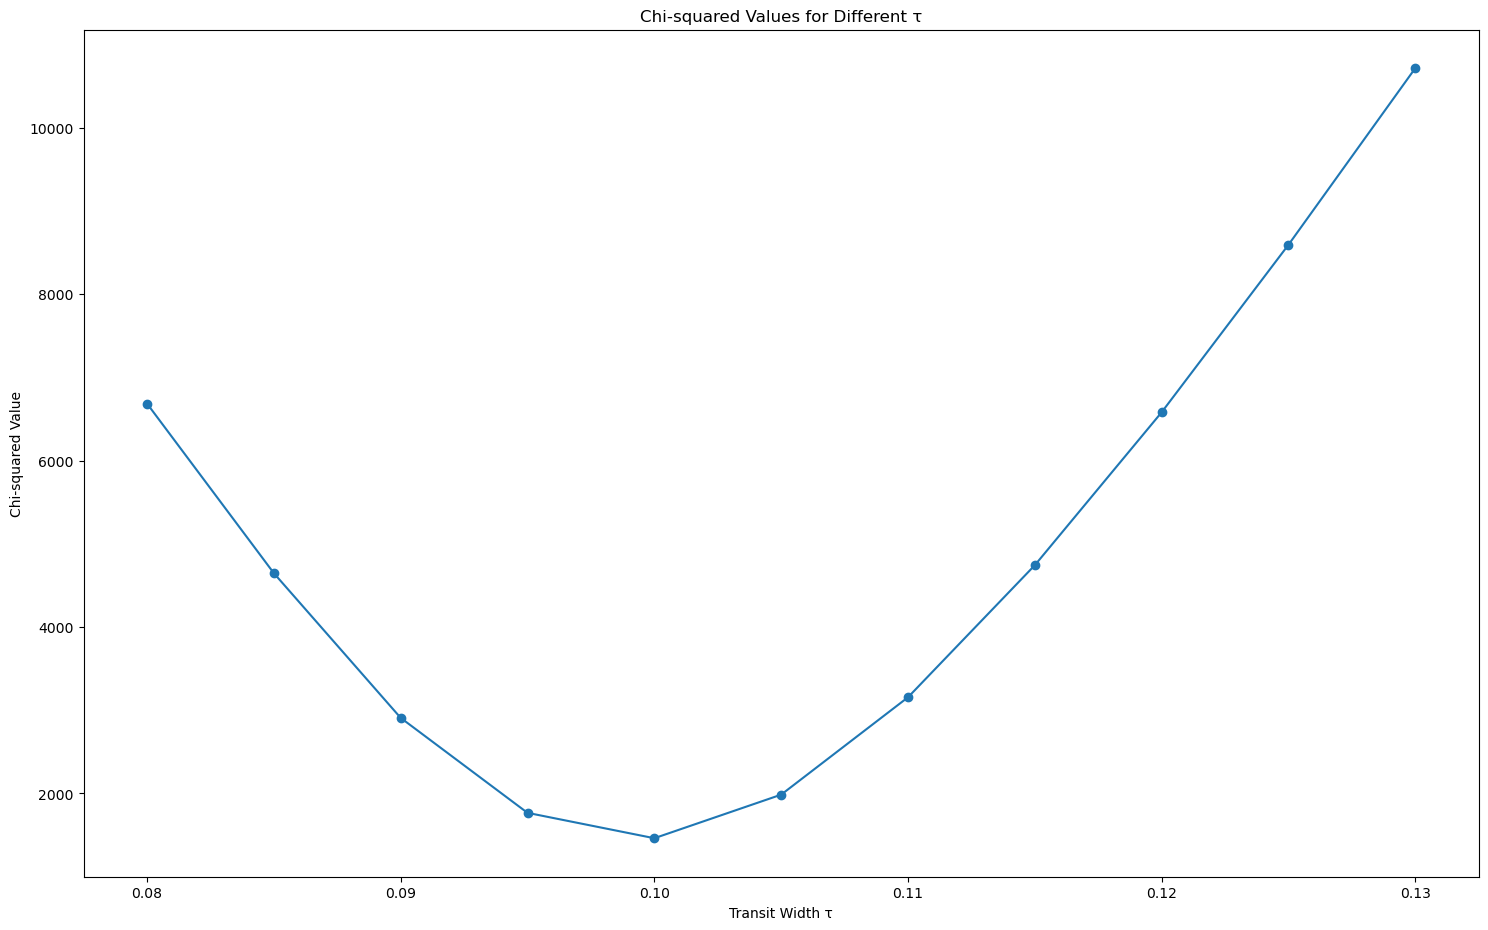

The best fitting τ value is: 0.10000000000000002
The minimum Chi-squared value is: 1461.9717094914108
The p-value for the best fit is: 0.45844875617023195


In [ ]:
#uses the incomlete gamma function, given the degrees of freedom to find p_value
p_value = gammaincc(dof / 2.0, min_chi_square / 2.0)

# chi-squared values against tau values
plt.plot(tau_values, chi_square_vals, marker='o')
plt.xlabel('Transit Width τ')
plt.ylabel('Chi-squared Value')
plt.title('Chi-squared Values for Different τ')
plt.show()

print(f"The best fitting τ value is: {best_tau}")
print(f"The minimum Chi-squared value is: {min_chi_square}")
print(f"The p-value for the best fit is: {p_value}")

Our minimum Chi sqaured happens at roughly 0.1 tau, which is the tau value we used earlier in the model. The plot of the diffferent Chi-sqaures from varying taus, shows that is it is the min.

In [ ]:
sigma = np.std(chi_square_vals)
print('The one sigma uncertainity is :' +str(sigma))

The one sigma uncertainity is :2871.101711017966
